<h2><center>Ensemble Learning</center></h2>

In [26]:
import os
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import KFold,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,VotingClassifier,BaggingRegressor,StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# Global settings


warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1
random_state = 42

In [2]:
data_train = pd.read_csv('data/train.csv')
data_val = pd.read_csv('data/val.csv')
data_val.shape

(3598, 44)

In [3]:
data_test = pd.read_csv('data/test.csv')
data_test.shape

(1333, 44)

In [4]:
data_test.columns.tolist()

['age',
 'job_ok',
 'nbre_enf',
 'ann_dipl',
 'ordre',
 'annee_ent',
 'date_ps',
 'dat_retraite',
 'dt_echeance',
 'tot_afct',
 'sexe_FEMININ',
 'sexe_MASCULIN',
 'sit_fam_CELIBATAIRE',
 'sit_fam_DIVORCE(E)',
 'sit_fam_MARIE(E)',
 'sit_fam_VEUF(VE)',
 'nature_APTITUDE PROFESSIONNEL',
 'nature_APTITUDE PROFESSIONNELLE',
 'nature_ATTESTATION',
 'nature_CERTIFICAT',
 'nature_DIPLOME',
 'nature_FORMATION',
 'statut_act_DECEDE(E)',
 'statut_act_EN FONCTION',
 'statut_act_FIN DE CONTRAT',
 'statut_act_RETRAITE(E)',
 'log_age',
 'log_job_ok',
 'log_nbre_enf',
 'log_ordre',
 'log_annee_ent',
 'log_date_ps',
 'log_dat_retraite',
 'log_dt_echeance',
 'log_tot_afct',
 'std_age',
 'std_job_ok',
 'std_nbre_enf',
 'std_ordre',
 'std_annee_ent',
 'std_date_ps',
 'std_dat_retraite',
 'std_dt_echeance',
 'std_tot_afct']

In [5]:
done=[
 'sexe_FEMININ',
 'sexe_MASCULIN',
 'sit_fam_CELIBATAIRE',
 'sit_fam_DIVORCE(E)',
 'sit_fam_MARIE(E)',
 'sit_fam_VEUF(VE)',
 'nature_APTITUDE PROFESSIONNEL',
 'nature_APTITUDE PROFESSIONNELLE',
 'nature_ATTESTATION',
 'nature_CERTIFICAT',
 'nature_DIPLOME',
 'nature_FORMATION',
 'statut_act_DECEDE(E)',
 'statut_act_EN FONCTION',
 'statut_act_FIN DE CONTRAT',
 'statut_act_RETRAITE(E)',
 'log_age',
 'log_job_ok',
 'log_nbre_enf',
 'log_ordre',
 'log_annee_ent',
 'log_date_ps',
 'log_dat_retraite',
 'log_dt_echeance',
 'std_age',
]

In [6]:
X=done
X_train = data_train[X]
X_test = data_test[X]
X_val = data_val[X]
y_train = data_train['log_tot_afct']
y_test = data_test['log_tot_afct']
y_val = data_val['log_tot_afct']

In [7]:
models_scores = []

def rmse(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    return mean_squared_error(y_train, y_pred, squared= False)
def rmse_val(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    return mean_squared_error(y_val, y_pred, squared= False)
def rmse_test(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred, squared= False)

In [8]:
linear_regression  = make_pipeline(LinearRegression())
score = rmse(linear_regression)
score_val =rmse_val(linear_regression)
models_scores.append(['LinearRegression', score])
print(f'LinearRegression Score= {score}')
# models_scores_val.append(['LinearRegression', score_val])
print(f'LinearRegression Score= {score_val}')

LinearRegression Score= 0.5159771223264767
LinearRegression Score= 0.5157241087285549


In [9]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state= random_state))

score = rmse(lasso)
models_scores.append(['Lasso', score])
print(f'Lasso Score= {score}')


Lasso Score= 0.5162731110227926


In [10]:
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio= .9, random_state= random_state))

score = rmse(elastic_net)
models_scores.append(['ElasticNet', score])
print(f'ElasticNet Score= {score}')

ElasticNet Score= 0.5162098101539428


In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[1, 10]}
model = Ridge()
Ridge_reg = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)
score = rmse(Ridge_reg)
models_scores.append(['Ridge', score])
print(f'KernelRidge Score= {score}')

KernelRidge Score= 0.5586800091415224


In [12]:
# Ranking the scores of each model
pd.DataFrame(models_scores).sort_values(by=[1], ascending=True)

,0,1
0,LinearRegression,0.515977
2,ElasticNet,0.516210
1,Lasso,0.516273
3,Ridge,0.558680


### Bagging

In [13]:
def bagging_predictions(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, y_train)

    br_y_pred = regr.predict(X_test)

    rmse_val = mean_squared_error(y_test, br_y_pred, squared= False) # squared= False > returns Root Mean Square Error   

    print(f'RMSE for base estimator {regr.base_estimator_} = {rmse_val}\n')
    return br_y_pred


predictions = np.column_stack((bagging_predictions(linear_regression),
                              bagging_predictions(lasso),
                              bagging_predictions(elastic_net),
                              bagging_predictions(Ridge_reg)))
print(f"Bagged predictions shape: {predictions.shape}")
       
y_pred = np.mean(predictions, axis=1)
print("Aggregated predictions (y_pred) shape", y_pred.shape)

rmse_val = mean_squared_error(y_test, y_pred, squared= False) # squared= False > returns Root Mean Square Error   
models_scores.append(['Bagging', rmse_val])

print(f'\nBagging RMSE= {rmse_val}')


RMSE for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = 0.5153470918235913

RMSE for base estimator Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0005, random_state=42))]) = 0.5154430542276491

RMSE for base estimator Pipeline(steps=[('robustscaler', RobustScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42))]) = 0.5153790323565538

RMSE for base estimator GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [1, 10]},
             scoring='neg_mean_squared_error') = 0.5654974491605192

Bagged predictions shape: (1333, 4)
Aggregated predictions (y_pred) shape (1333,)

Bagging RMSE= 0.519491901902987


In [14]:
pd.DataFrame(models_scores).sort_values(by=[1], ascending=True)

,0,1
0,LinearRegression,0.515977
2,ElasticNet,0.516210
1,Lasso,0.516273
4,Bagging,0.519492
3,Ridge,0.558680


## RandomForestRegressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

def tunning(parameters,X_train,y_train):
    radom_forest = RandomForestRegressor()
    grid_GBR = RandomizedSearchCV(random_state=42,estimator=radom_forest, param_distributions = parameters, cv = 5, n_jobs=-1,n_iter = 10)
    grid_GBR.fit(X_train, y_train)
    return grid_GBR

parameters = {'bootstrap': [True],
    'max_depth': [None, 10, 20, 30],
    'max_features': range(20, 27),
    'min_samples_leaf': [3, 4, 5,1],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
                 }
search = tunning(parameters,X_train,y_train)

In [16]:
search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 21,
 'max_depth': 30,
 'bootstrap': True}

In [17]:
rf=search.best_estimator_
val_pred = rf.predict(X_val)
train_pred = rf.predict(X_train)

In [18]:
trainrmse = (metrics.mean_squared_error(y_train, train_pred ))
rmse = (metrics.mean_squared_error(y_val, val_pred))
print("RMSE train :",trainrmse)
print("RMSE test :",rmse)

RMSE train : 0.008244961859785948
RMSE test : 0.023409429479427382


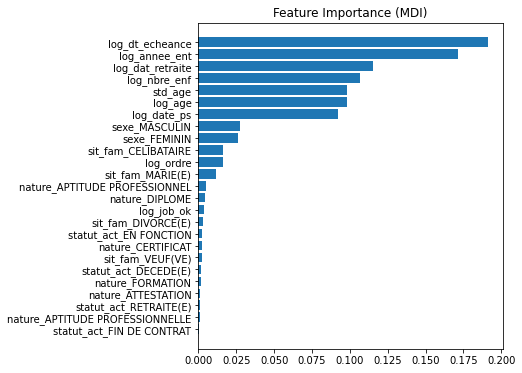

In [19]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(done)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

### Boosting 

#### GradientBoostingRegressor

In [20]:
def tunning(parameters,X_val,y_val):
    GBR = GradientBoostingRegressor()
    grid_GBR = RandomizedSearchCV(random_state=42,estimator=GBR, param_distributions = parameters, cv = 2, n_jobs=-1,n_iter = 10)
    grid_GBR.fit(X_train, y_train)
    return grid_GBR

In [21]:
parameters = {'learning_rate': [0.01,0.02,0.03],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,6,8]
                 }
search = tunning(parameters,X_val,y_val)

In [22]:
search.best_params_

{'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.03}

In [23]:
gb=search.best_estimator_
test_pred = gb.predict(X_val)
train_pred = gb.predict(X_train)
trainrmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred ))
rms = np.sqrt(metrics.mean_squared_error(y_val, val_pred))
print("RMSE train :",trainrmse)
print("RMSE val :",rms)

RMSE train : 0.1606815300125441
RMSE val : 0.15300140352110297


### Feature Importance

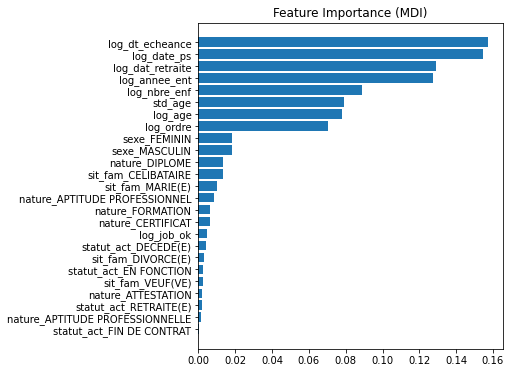

In [24]:
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(done)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

#### XGBRegressor 

In [25]:
xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = random_state)
score = rmse(xgb_regressor)
score_val = rmse_val(xgb_regressor)
models_scores.append(['XGBRegressor', score])
print(f'XGBRegressor Score= {score}')
print(f'XGBRegressor Score= {score_val}')

AttributeError: module 'xgboost' has no attribute 'XGBRegressor'

#### LGBMRegressor

In [ ]:
import re
X_train= X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgbm_regressor = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state = random_state)

score = rmse(lgbm_regressor)
models_scores.append(['LGBMRegressor', score])
print(f'LGBMRegressor Score= {score}')

### Stacking

In [ ]:
estimators = [ ('elastic_net', elastic_net),('xgb_regressor', xgb_regressor) ]

stack = StackingRegressor(estimators=estimators, final_estimator= lasso, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, y_train)

pred = stack.predict(X_test)

rmse_val = mean_squared_error(y_test, pred, squared= False) # squared= False > returns Root Mean Square Error    
models_scores.append(['Stacking', rmse_val])
print(f'rmse= {rmse_val}')

In [ ]:
# d=pd.DataFrame(models_scores2,columns=['Model', 'RMSE Train'])
d=pd.DataFrame(models_scores,columns=['Model', 'RMSE Train'])
d.sort_values(by=['RMSE Train'], ascending=True)

## Validation

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
d=rmsle_cv(rf)